In [1]:
#if you have not installed tabulate 
#this is just for printing the information of data in a prettier format
! pip install tabulate

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Testing Function

In [2]:
#import main code
from OurTrainingTools import *
#this will throw a random number and print it
#to reset the random number manually, use
#torch.manual_seed(random_seed)


def test_model(madminermodel, test_input_sm, test_input_bsm, bsmparval, NSM, NBSM, epochs, e, n_meas, pm, verbose_t=True, verbose_period_t=1e5, title=''):
        
        # computing test statistics t (or lambda) in equation (2) of paper
        def compute_t(madminermodel, nev, counter, test_input):
            # generate number of points for testing under Poisson distribution
            n_gen = 0
            while n_gen == 0:
                n_gen = np.random.poisson(nev)
            
            # stop if there are no more points to test
            if (counter + n_gen) >= len(test_input):
                return 0., -1
            
            points = test_input[int(counter): int(counter+n_gen)]
            
            # compute test statistics
            log_ratio = (madminermodel.evaluate_log_likelihood_ratio(points.numpy(), 
                                            np.array([0.]), np.array([bsmparval,]))[0][0])
            log_ratio = torch.tensor(log_ratio)
            #ratio = 1./ratio
            log_ratio = log_ratio
            out  = 2 * (NBSM - NSM - (log_ratio+torch.log(torch.tensor(NBSM/NSM))).sum(0))
            
            #return test statistics and the starting point for the next batch
            return out, int(counter+n_gen)
        
        test_start = time.time()
        if verbose_t:
            print("NSM = %.3f --- NBSM = %.3f"%(NSM, NBSM))
        tsm  = torch.empty(n_meas)
        tbsm = torch.empty(n_meas)
        
        # empty array to store values
        tsmcount  = torch.zeros(n_meas+1)
        tbsmcount = torch.zeros(n_meas+1)
            
        for i in range(n_meas):
            tsm[i], tsmcount[i+1] = compute_t(madminermodel, NSM, tsmcount[i], 
                                       test_input_sm)
            tbsm[i], tbsmcount[i+1] = compute_t(madminermodel, NBSM, tbsmcount[i], 
                                       test_input_bsm)
            
            if (tsmcount[i+1] < 0) or (tbsmcount[i+1] < 0):
                print('Reaching the end of test data. Stop tests at %d. '%i)
                tsm, tbsm = tsm[: i], tbsm[: i]
                n_meas = i
                break
                
            if i % (verbose_period_t) == 0:
                print('test %s: tsm = %.3f,  tbsm = %.3f'%(
                        str(i).ljust(4), tsm[i], tbsm[i]))
        
        test_duration = time.time() - test_start
        #compute mean and variation of the test statistics in two hypotheses
        mu_sm     = tsm.mean().item()
        mu_bsm    = tbsm.mean().item()
        sigma_sm  = tsm.std().item()
        sigma_bsm = tbsm.std().item()
        med_sm    = tsm.median().item()
        
        #compute separation and p-value
        sep    = (mu_sm - mu_bsm)/sigma_bsm
        p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm) 
        #print(len([i for i in tbsm if i>med_sm]))
        delta1 = (p * (1 - p)/n_meas)**0.5
        delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
                2 * sigma_bsm**2))/(2*(n_meas**0.5))
        print('===> delta1 = %.3f, delta2 = %.3f'%(delta1, delta2))
        deltap = (delta1**2 + delta2**2)**0.5
        
        results_path = os.getcwd()
        
        if verbose_t:
            print('p = %.3f +/- %.3f' %(p, deltap))
            print('Separation = %.2f sigmas'%(sep))
            training_properties = '/toydata/madminer-carl-'+title
            plot_histogram(tsm, tbsm, int(NSM), int(NBSM), p, deltap, sep, epochs, e, 
                                training_properties, results_path)
            print('Partial test after %d epochs (took %.2f seconds)\n'
                          %(e, test_duration))
            
        
        return sep, p, tsm, tbsm

=========== Random Seed: 1325 ===========


In [3]:
#import main code
from OurTrainingTools import *
#this will throw a random number and print it
#to reset the random number manually, use
#torch.manual_seed(random_seed)


def test_model_qc(model, test_input_sm, test_input_bsm, bsmparval, NSM, NBSM, epochs, e, n_meas, pm, verbose_t=True, verbose_period_t=1e5, title=''):
        
        # computing test statistics t (or lambda) in equation (2) of paper
        def compute_t(model, nev, counter, test_input):
            # generate number of points for testing under Poisson distribution
            n_gen = 0
            while n_gen == 0:
                n_gen = np.random.poisson(nev)
            
            # stop if there are no more points to test
            if (counter + n_gen) >= len(test_input):
                return 0., -1
            
            points = test_input[int(counter): int(counter+n_gen)]
            
            # compute test statistics
            #print(points)
            y = model.Forward(points, np.ones(len(points))*bsmparval).detach()
            log_ratio = np.log(y/(1.-y))
            #calculate_ratio
            #log_ratio = torch.tensor(log_ratio)
            out  = 2 * (NBSM - NSM - (log_ratio+torch.log(torch.tensor(NBSM/NSM))).sum(0))
            
            #return test statistics and the starting point for the next batch
            return out, int(counter+n_gen)
        
        test_start = time.time()
        if verbose_t:
            print("NSM = %.3f --- NBSM = %.3f"%(NSM, NBSM))
        tsm  = torch.empty(n_meas)
        tbsm = torch.empty(n_meas)
        
        # empty array to store values
        tsmcount  = torch.zeros(n_meas+1)
        tbsmcount = torch.zeros(n_meas+1)
            
        for i in range(n_meas):
            tsm[i], tsmcount[i+1] = compute_t(model, NSM, tsmcount[i], 
                                       test_input_sm)
            tbsm[i], tbsmcount[i+1] = compute_t(model, NBSM, tbsmcount[i], 
                                       test_input_bsm)
            
            if (tsmcount[i+1] < 0) or (tbsmcount[i+1] < 0):
                print('Reaching the end of test data. Stop tests at %d. '%i)
                tsm, tbsm = tsm[: i], tbsm[: i]
                n_meas = i
                break
                
            if i % (verbose_period_t) == 0:
                print('test %s: tsm = %.3f,  tbsm = %.3f'%(
                        str(i).ljust(4), tsm[i], tbsm[i]))
        
        test_duration = time.time() - test_start
        
        #compute mean and variation of the test statistics in two hypotheses
        mu_sm     = tsm.mean().item()
        mu_bsm    = tbsm.mean().item()
        sigma_sm  = tsm.std().item()
        sigma_bsm = tbsm.std().item()
        med_sm    = tsm.median().item()
        
        #compute separation and p-value
        sep    = (mu_sm - mu_bsm)/sigma_bsm
        p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm) 
        #print(len([i for i in tbsm if i>med_sm]))
        delta1 = (p * (1 - p)/n_meas)**0.5
        delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
                2 * sigma_bsm**2))/(2*(n_meas**0.5))
        print('===> delta1 = %.3f, delta2 = %.3f'%(delta1, delta2))
        deltap = (delta1**2 + delta2**2)**0.5
        
        results_path = os.getcwd()
        if verbose_t:
            print('p = %.3f +/- %.3f' %(p, deltap))
            print('Separation = %.2f sigmas'%(sep))
            training_properties = title
            plot_histogram(tsm, tbsm, int(NSM), int(NBSM), p, deltap, sep, epochs, e, 
                                training_properties, results_path)
            print('Partial test after %d epochs (took %.2f seconds)\n'
                          %(e, test_duration))
            
        
        return sep, p, tsm, tbsm

In [4]:
def combine_pm(tsm_plus, tbsm_plus, tsm_minus, tbsm_minus, e):
    len_sm    = min(len(tsm_plus), len(tsm_minus))
    len_bsm   = min(len(tbsm_plus), len(tbsm_minus))
    
    tsm       = (tsm_plus[:len_sm] + tsm_minus[:len_sm])
    tbsm      = (tbsm_plus[:len_bsm] + tbsm_minus[:len_bsm])
    
    mu_sm     = tsm.mean().item()
    mu_bsm    = tbsm.mean().item()
    sigma_sm  = tsm.std().item()
    sigma_bsm = tbsm.std().item()
    med_sm    = tsm.median().item()
    
    sep    = (mu_sm - mu_bsm)/sigma_bsm
    p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm)
    
    delta1 = (p * (1 - p)/min(len_sm, len_bsm))**0.5
    delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
            2 * sigma_bsm**2))/(2*(n_meas**0.5))
    deltap = (delta1**2 + delta2**2)**0.5
    
    title = '%s, %s%s, combined, %s, N=%d, epochs=%d'%(
                     outputheader, str(n_neurons), bsm_op, bsm_test, N, e)

    simpleplot(tsm, tbsm, title, sep, p, deltap)
    
    return (p, deltap)

In [5]:
def plot_histogram(tsm, tbsm, nsm, nbsm, p, deltap, sep, epochs, 
                   e, training_properties, results_folder):
    mint = torch.min(torch.cat((tsm, tbsm))).item()
    maxt = torch.max(torch.cat((tsm, tbsm))).item()
    
    # for some reason the code complains if i don't detach the variables 
    # from their grad-on versions
    tsm, tbsm = tsm.detach(), tbsm.detach()
    
    bins = np.linspace(mint, maxt, 60)
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    plt.hist(tsm,  bins, alpha=0.5, label='SM')
    plt.hist(tbsm, bins, alpha=0.5, label='BSM')
    plt.legend(loc='upper right')
    
    sn   = 'nsm = %s \nnbsm = %s'%(str(nsm), str(nbsm))
    sp   = 'p      '+'= '+ ('%.3f +/- %.3f'%(p, deltap))
    ssep = 'sep   ' + '= ' + ('%.3f'%(sep))
    
    plt.text(x=0.05, y=0.85, transform=ax.transAxes, 
         s=sn+'\n'+sp+'\n'+ssep, bbox=dict(facecolor='blue', alpha=0.2))
    plt.xlabel('t')
    plt.ylabel('p(t)')
    if epochs == e:
        plt.title('Final test\n' + training_properties)
        filename = results_folder + training_properties \
                    + ' histogram.pdf'
        plt.savefig(filename)
        return 
    plt.title(training_properties)
    plt.show()
    
    return

In [6]:
def TestEstimator(estimator, bsmval, bsm_fname='', withXS=True, title_message='', qc=False):
    #name of operator
    op_name = bsm_fname.split('_')[0]
    bsmval_name = bsm_fname.split('_')[-2] 
    
    #toy data file path
    f = h5py.File(os.getcwd()+'/toydata/%s.h5'%(bsm_fname), 'r')

    #parse data 
    Data = np.array(f['Data'])
    Labels = np.array(f['Labels'])
    NSM = np.array(f['NSM'])
    
    
    if withXS:
        NBSMList = np.array(f['NBSMList'])
        NBSM = NBSMList[0]
    else:
        NBSM = NSM
        
    #randomise
    Idx_test = torch.randperm(len(Data))
    Data_test = torch.Tensor(Data[Idx_test])
    Label_test = torch.Tensor(Labels[Idx_test])

    #print(Data.mean(0), Data.std(0))
    
    #select data from each hypothesis
    SM_Data  = Data_test[Label_test==0, :]
    BSM_Data = Data_test[Label_test==1, :]

    #for plotting/ printing
    #n_epochs = current_epoch = int(1e4)
    n_epochs = int(1e4)
    current_epoch = 0
    results_path = os.getcwd()
    charge = 'plus'

    #number of tests thrown on the data
    #the test function will stop automatically if points run out
    n_meas = 4000

    if withXS:
        if not qc:
            sep, p, tsm, tbsm = test_model(estimator, SM_Data, BSM_Data, bsmval, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
                  verbose_t=True, verbose_period_t=1e5, title='%s = %s'%(op_name, bsmval_name)+title_message)
        else:
            sep, p, tsm, tbsm = test_model_qc(estimator, SM_Data, BSM_Data, bsmval, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
                  verbose_t=True, verbose_period_t=1e5, title='%s = %s'%(op_name, bsmval_name)+title_message)
    else:
        if not qc:
            sep, p, tsm, tbsm = test_model(estimator, SM_Data, BSM_Data, bsmval, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
              verbose_t=True, verbose_period_t=1e5, title='%s = %s'%(op_name, bsmval_name)+title_message)
        else:
            sep, p, tsm, tbsm = test_model_qc(estimator, SM_Data, BSM_Data, bsmval, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
              verbose_t=True, verbose_period_t=1e5, title='%s = %s'%(op_name, bsmval_name)+title_message)
        
        
    f.close()
    return sep, p, tsm, tbsm

## Reading Model

## Charge Plus

In [7]:
estimator = OurModel(AR=[9, 32, 32, 32, 32, 1])
estimator.Load_CPU('ChPgw_355', os.getcwd()+'/models/')

Model successfully loaded.
Path: /madminer/madminer/examples/tutorial_particle_physics/models/ChPgw_355.pth


NSM = 2225.504 --- NBSM = 2225.504
test 0   : tsm = -13.199,  tbsm = -15.997
Reaching the end of test data. Stop tests at 224. 
===> delta1 = 0.017, delta2 = 0.014
p = 0.071 +/- 0.022
Separation = 1.31 sigmas


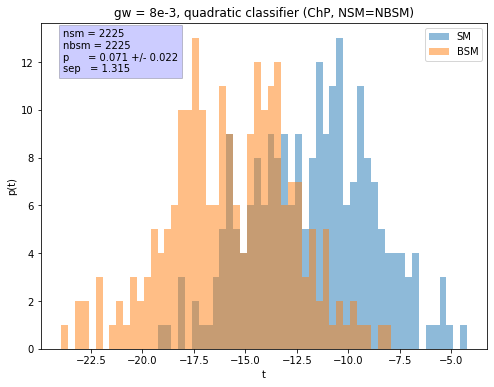

Partial test after 0 epochs (took 1.25 seconds)

NSM = 2225.504 --- NBSM = 2225.504
test 0   : tsm = -19.627,  tbsm = -12.726
Reaching the end of test data. Stop tests at 224. 
===> delta1 = 0.012, delta2 = 0.008
p = 0.036 +/- 0.015
Separation = 1.67 sigmas


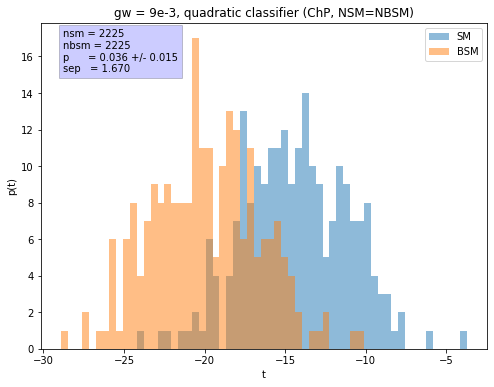

Partial test after 0 epochs (took 1.14 seconds)

NSM = 2225.504 --- NBSM = 2225.504
test 0   : tsm = -10.455,  tbsm = -23.507
Reaching the end of test data. Stop tests at 223. 
===> delta1 = 0.015, delta2 = 0.008
p = 0.054 +/- 0.017
Separation = 1.62 sigmas


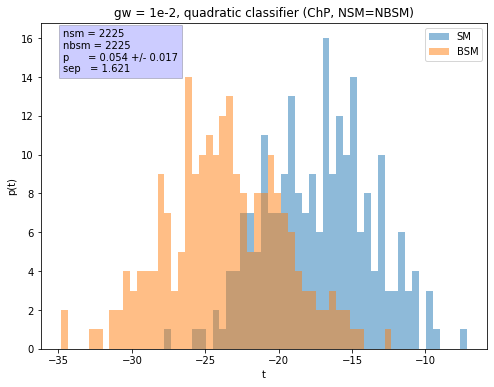

Partial test after 0 epochs (took 1.08 seconds)



In [20]:
gwvals = [8e-3, 9e-3, 1e-2]
gwval_fnames = ['gw_toydata_test_8e-3_out','gw_toydata_test_9e-3_out','gw_toydata_test_1e-2_out']
tsm_plus = {}
tbsm_plus = {}

for gwval, gwval_fname in zip(gwvals, gwval_fnames):
    sep, p, tsm, tbsm =TestEstimator(estimator, gwval , gwval_fname, withXS=False,
                                     title_message=', quadratic classifier (ChP, NSM=NBSM)', qc=True)
    tsm_plus[gwval] = tsm
    tbsm_plus[gwval]=tbsm

NSM = 2225.504 --- NBSM = 2231.468
test 0   : tsm = -15.342,  tbsm = -16.339
Reaching the end of test data. Stop tests at 224. 
===> delta1 = 0.012, delta2 = 0.012
p = 0.036 +/- 0.017
Separation = 1.41 sigmas


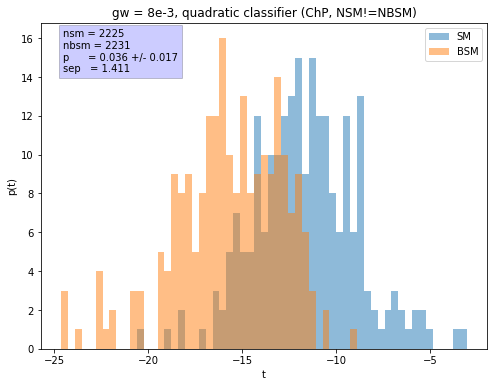

Partial test after 0 epochs (took 1.06 seconds)

NSM = 2225.504 --- NBSM = 2233.180
test 0   : tsm = -8.508,  tbsm = -15.734
Reaching the end of test data. Stop tests at 223. 
===> delta1 = 0.017, delta2 = 0.009
p = 0.067 +/- 0.019
Separation = 1.60 sigmas


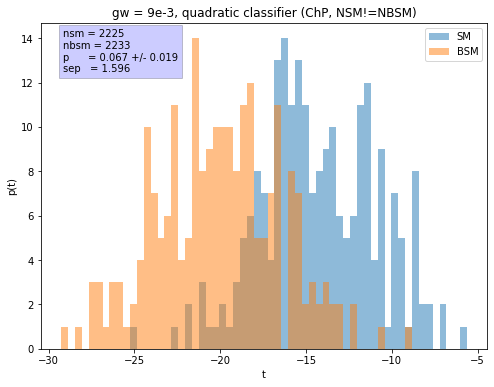

Partial test after 0 epochs (took 1.09 seconds)

NSM = 2225.504 --- NBSM = 2234.707
test 0   : tsm = -18.775,  tbsm = -24.086
Reaching the end of test data. Stop tests at 223. 
===> delta1 = 0.012, delta2 = 0.007
p = 0.036 +/- 0.014
Separation = 1.68 sigmas


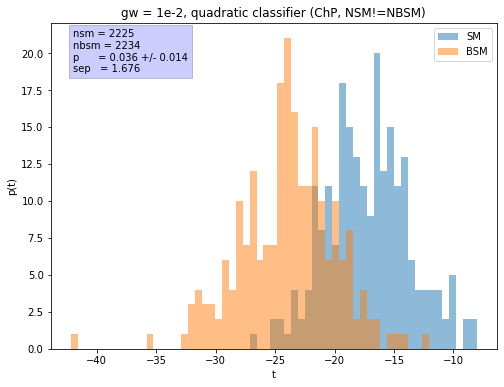

Partial test after 0 epochs (took 1.02 seconds)



In [21]:
gwvals = [8e-3, 9e-3, 1e-2]
gwval_fnames = ['gw_toydata_test_8e-3_out','gw_toydata_test_9e-3_out','gw_toydata_test_1e-2_out']
tsm_plus_XS = {}
tbsm_plus_XS = {}

for gwval, gwval_fname in zip(gwvals, gwval_fnames):
    sep, p, tsm, tbsm =TestEstimator(estimator, gwval , gwval_fname, withXS=True,
                                     title_message=', quadratic classifier (ChP, NSM!=NBSM)', qc=True)
    tsm_plus_XS[gwval] = tsm
    tbsm_plus_XS[gwval]=tbsm

### madminer

In [10]:
from madminer import ParameterizedRatioEstimator
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup_gw.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl1000-bigbatch-gw')

NSM = 2225.504 --- NBSM = 2231.468
test 0   : tsm = 91.228,  tbsm = 133.443
Reaching the end of test data. Stop tests at 224. 
===> delta1 = 0.032, delta2 = 0.031
p = 0.335 +/- 0.045
Separation = 0.41 sigmas


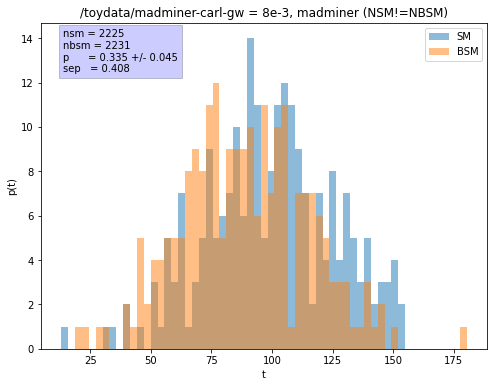

Partial test after 0 epochs (took 39.46 seconds)

NSM = 2225.504 --- NBSM = 2233.180
test 0   : tsm = 124.618,  tbsm = 77.411
Reaching the end of test data. Stop tests at 223. 
===> delta1 = 0.032, delta2 = 0.026
p = 0.359 +/- 0.041
Separation = 0.43 sigmas


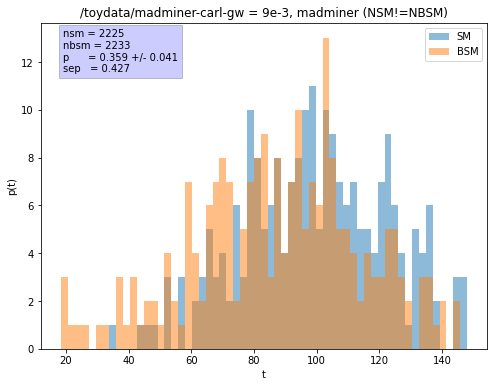

Partial test after 0 epochs (took 40.72 seconds)

NSM = 2225.504 --- NBSM = 2234.707
test 0   : tsm = 108.562,  tbsm = 111.864
Reaching the end of test data. Stop tests at 224. 
===> delta1 = 0.031, delta2 = 0.030
p = 0.326 +/- 0.043
Separation = 0.50 sigmas


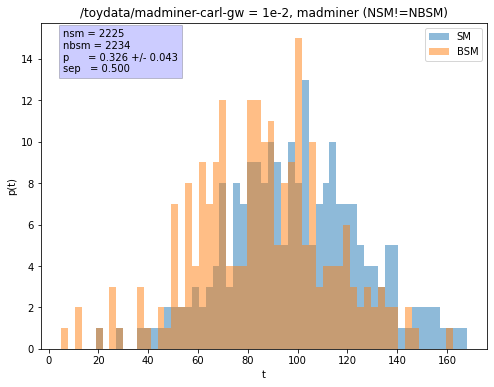

Partial test after 0 epochs (took 40.12 seconds)



In [11]:
gwval = 8e-3
gwval_name = 'gw_toydata_test_8e-3_out'

gwvals = [8e-3, 9e-3, 1e-2]
gwval_fnames = ['gw_toydata_test_8e-3_out','gw_toydata_test_9e-3_out','gw_toydata_test_1e-2_out']

for gwval, gwval_fname in zip(gwvals, gwval_fnames):
    TestEstimator(estimator, gwval , gwval_fname, title_message=', madminer (NSM!=NBSM)', qc=False)

## Charge Minus

In [23]:
estimator = OurModel(AR=[9, 32, 32, 32, 32, 1])
estimator.Load_CPU('ChMgw_355', os.getcwd()+'/models/')

Model successfully loaded.
Path: /madminer/madminer/examples/tutorial_particle_physics/models/ChMgw_355.pth


NSM = 987.026 --- NBSM = 987.026
test 0   : tsm = -5.285,  tbsm = -7.844
Reaching the end of test data. Stop tests at 507. 
===> delta1 = 0.019, delta2 = 0.016
p = 0.239 +/- 0.025
Separation = 0.70 sigmas


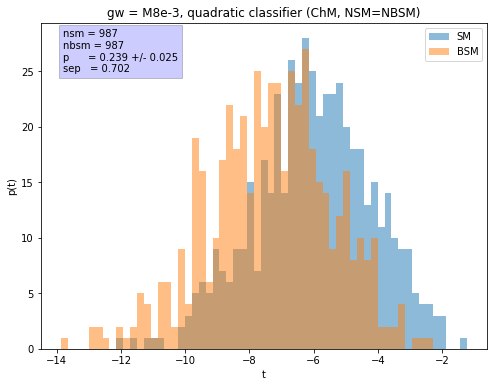

Partial test after 0 epochs (took 4.08 seconds)

NSM = 987.026 --- NBSM = 987.026
test 0   : tsm = -6.804,  tbsm = -10.550
Reaching the end of test data. Stop tests at 506. 
===> delta1 = 0.018, delta2 = 0.015
p = 0.204 +/- 0.023
Separation = 0.83 sigmas


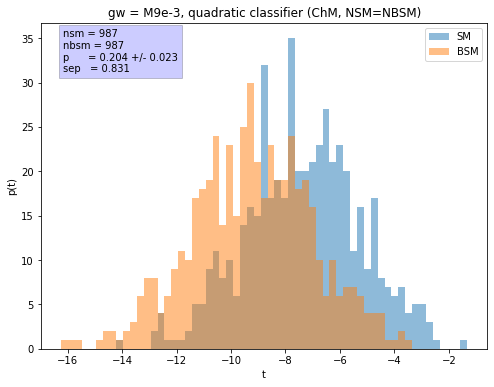

Partial test after 0 epochs (took 4.08 seconds)

NSM = 987.026 --- NBSM = 987.026
test 0   : tsm = -6.277,  tbsm = -9.591
Reaching the end of test data. Stop tests at 506. 
===> delta1 = 0.016, delta2 = 0.013
p = 0.152 +/- 0.021
Separation = 0.98 sigmas


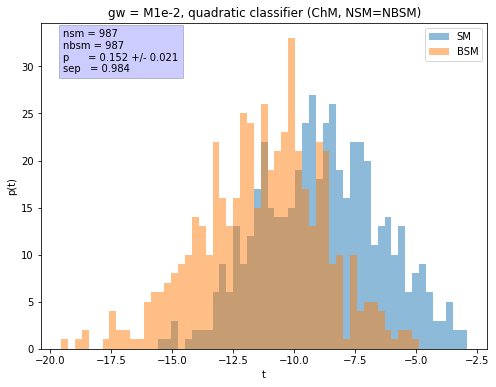

Partial test after 0 epochs (took 4.10 seconds)



In [24]:
gwvals = [8e-3, 9e-3, 1e-2]
gwval_fnames = ['gw_toydata_test_M8e-3_out','gw_toydata_test_M9e-3_out','gw_toydata_test_M1e-2_out']

tsm_minus = {}
tbsm_minus = {}

for gwval, gwval_fname in zip(gwvals, gwval_fnames):
    sep, p, tsm, tbsm =TestEstimator(estimator, gwval , gwval_fname, withXS=False,
                                     title_message=', quadratic classifier (ChM, NSM=NBSM)', qc=True)
    tsm_minus[gwval] = tsm
    tbsm_minus[gwval]=tbsm

NSM = 987.026 --- NBSM = 989.107
test 0   : tsm = -5.026,  tbsm = -11.435
Reaching the end of test data. Stop tests at 506. 
===> delta1 = 0.018, delta2 = 0.017
p = 0.215 +/- 0.025
Separation = 0.70 sigmas


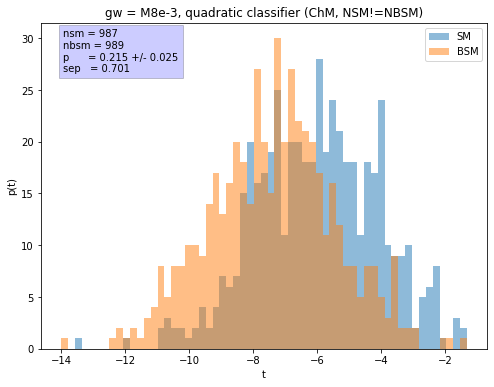

Partial test after 0 epochs (took 3.94 seconds)

NSM = 987.026 --- NBSM = 989.750
test 0   : tsm = -6.550,  tbsm = -8.316
Reaching the end of test data. Stop tests at 504. 
===> delta1 = 0.018, delta2 = 0.015
p = 0.200 +/- 0.023
Separation = 0.84 sigmas


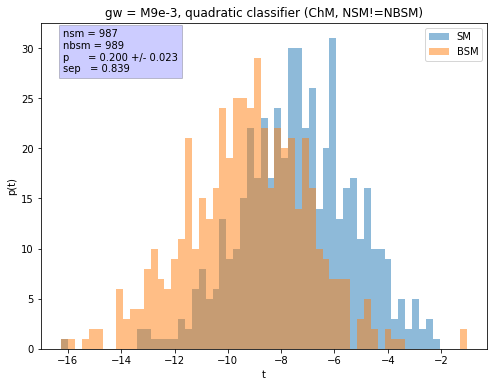

Partial test after 0 epochs (took 4.02 seconds)

NSM = 987.026 --- NBSM = 990.530
test 0   : tsm = -7.249,  tbsm = -10.061
Reaching the end of test data. Stop tests at 504. 
===> delta1 = 0.017, delta2 = 0.013
p = 0.169 +/- 0.021
Separation = 0.94 sigmas


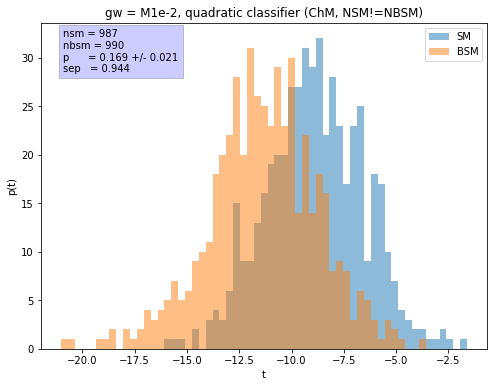

Partial test after 0 epochs (took 4.03 seconds)



In [25]:
gwvals = [8e-3, 9e-3, 1e-2]
gwval_fnames = ['gw_toydata_test_M8e-3_out','gw_toydata_test_M9e-3_out','gw_toydata_test_M1e-2_out']

tsm_minus_XS = {}
tbsm_minus_XS = {}

for gwval, gwval_fname in zip(gwvals, gwval_fnames):
    sep, p, tsm, tbsm =TestEstimator(estimator, gwval , gwval_fname, withXS=True,
                                     title_message=', quadratic classifier (ChM, NSM!=NBSM)', qc=True)
    tsm_minus_XS[gwval] = tsm
    tbsm_minus_XS[gwval]=tbsm

## Combine

In [26]:
def combine_pm(tsm_plus, tbsm_plus, tsm_minus, tbsm_minus, n_meas, outputheader, bsm_op):
    len_sm    = min(len(tsm_plus), len(tsm_minus))
    len_bsm   = min(len(tbsm_plus), len(tbsm_minus))
    
    tsm       = (tsm_plus[:len_sm] + tsm_minus[:len_sm])
    tbsm      = (tbsm_plus[:len_bsm] + tbsm_minus[:len_bsm])
    
    mu_sm     = tsm.mean().item()
    mu_bsm    = tbsm.mean().item()
    sigma_sm  = tsm.std().item()
    sigma_bsm = tbsm.std().item()
    med_sm    = tsm.median().item()
    
    sep    = (mu_sm - mu_bsm)/sigma_bsm
    p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm)
    
    delta1 = (p * (1 - p)/min(len_sm, len_bsm))**0.5
    delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
            2 * sigma_bsm**2))/(2*(n_meas**0.5))
    deltap = (delta1**2 + delta2**2)**0.5
    
    title = '%s, %s, combined'%(
                     outputheader, bsm_op)

    simpleplot(tsm, tbsm, title, sep, p, deltap)
    
    return (p, deltap)

def simpleplot(tsm, tbsm, title, sep, p, deltap):
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    plt.hist(tsm,  50, alpha=0.5, label='SM')
    plt.hist(tbsm, 50, alpha=0.5, label='BSM')
    plt.title(title)
    plt.legend(loc='upper right')
    
    plt.text(x=0.05, y=0.85, transform=ax.transAxes, 
         s='sep = %.3f\np = %.3f +/- %.3f'%(sep, p, deltap), 
         bbox=dict(facecolor='blue', alpha=0.2))
    
    plt.savefig(os.getcwd() + '/models/' + title+'.pdf')
    plt.show()

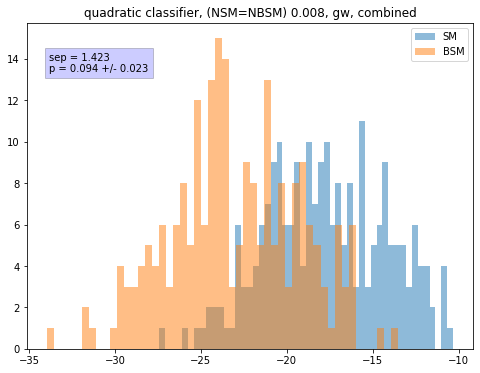

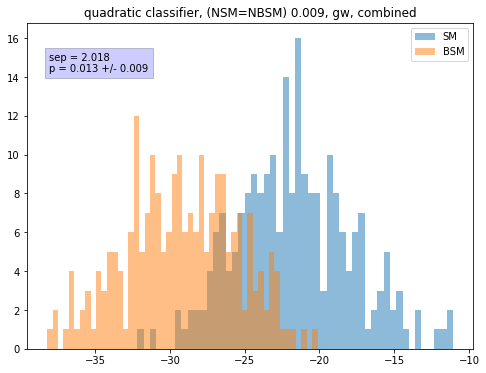

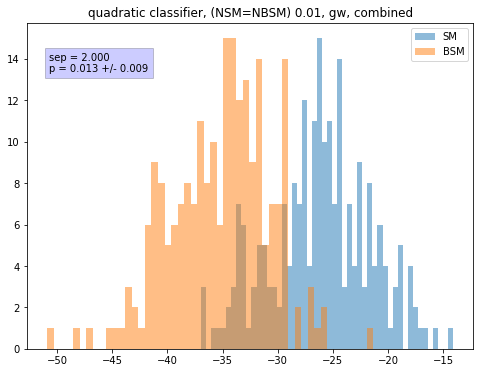

In [27]:
n_meas = 200

gwvals = [8e-3, 9e-3, 1e-2]

for gwval in gwvals:
    combine_pm(tsm_plus[gwval], tbsm_plus[gwval], tsm_minus[gwval], tbsm_minus[gwval], 
           n_meas,'quadratic classifier, (NSM=NBSM) %s'%str(gwval), 'gw')

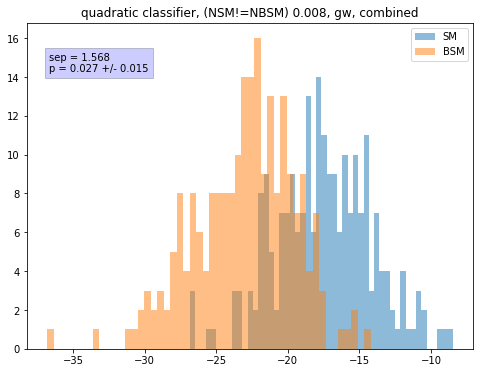

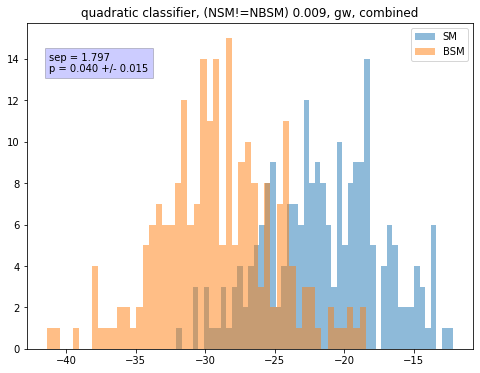

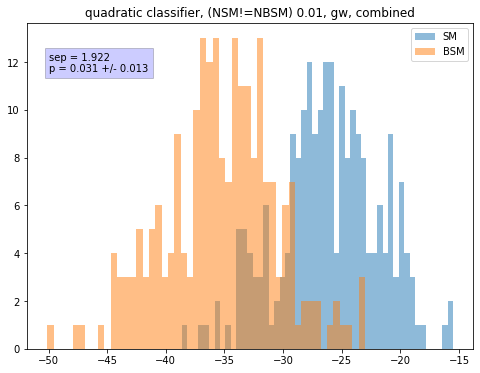

In [28]:
n_meas = 200

gwvals = [8e-3, 9e-3, 1e-2]

for gwval in gwvals:
    combine_pm(tsm_plus_XS[gwval], tbsm_plus_XS[gwval], tsm_minus_XS[gwval], tbsm_minus_XS[gwval], 
           n_meas,'quadratic classifier, (NSM!=NBSM) %s'%str(gwval), 'gw')